# Energy calculations with F-SAC

In this notebook, we use our SAC equations as the basis for F-SAC calculations.

The F-SAC model uses the exact same SAC equations but with the compound segments defined by a group
contribution method and interaction among groups as in the COSMO-SAC/RS models.

The basic literature is:
 - [Functional-Segment Activity Coefficient model. 1. Model formulation](http://dx.doi.org/10.1021/ie400170a). Industrial & Engineering Chemistry Research, v. 52, p. 11159-11171, 2013.
 - [Functional-Segment Activity Coefficient model. 2. Associating mixtures](http://dx.doi.org/10.1021/ie4013979). Industrial & Engineering Chemistry Research, v. 52, p. 11172-11181, 2013.

We start by importing the necessary packages.

In [10]:
import os, sys
import matplotlib.pyplot as plt
import pandas as pd

parent_directory = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_directory)

from pysac import SAC

### Compound definitions

In F-SAC, compounds are defined with just a few surface areas and their respective charge densities.

Linear hydrocarbons are all neutral and polar compounds have a neutral, positive, and negative portions.

For **acetone**, our first compound, we have three segment types, neutral, positive, and negative. While **n-hexane** can be represented by a single segment type, all neutral.

In [11]:
sigma_1 = [0,      0.0132, -0.00363]
Q_1     = [20.167, 21.97,  80.23]

sigma_2 = [0.0]
Q_2     = [191.93]

We can plot the sigma-profiles of these compounds if we want:

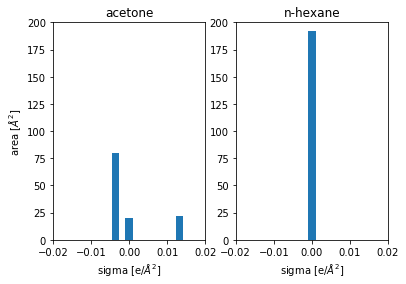

In [12]:
plt.subplot(1, 2, 1)
plt.bar(sigma_1, Q_1, width = 0.002)
plt.title('acetone')
plt.xlabel(r'sigma [e/$\AA^2$]')
plt.ylabel(r'area [$\AA^2$]')
plt.ylim([0, 200])
plt.xlim([-0.02, 0.02])

plt.subplot(1, 2, 2)
plt.bar(sigma_2, Q_2, width = 0.002)
plt.title('n-hexane')
plt.xlabel(r'sigma [e/$\AA^2$]')
plt.xlim([-0.02, 0.02])
plt.ylim([0, 200])

plt.savefig('pdf/f-sac-profiles.pdf')
plt.show()

## F-SAC implementation

Now we derive our general SAC equations to work as a F-SAC implementation by deriving the basic `SAC` class and implementing the method calculating the interaction energies, `calc_u`.

In [13]:
# F-SAC parameters
alpha = 8544.6
Q_eff = 3.597

# The mixture area and sigma arrays
Q = [Q_1, Q_2]
sigma = [sigma_1, sigma_2]

class FSACNonHB(SAC):
    def __init__(self):
        super().__init__(Q_eff=Q_eff)

    def calc_u(self, T, i, j, m, n):
        '''
        Interaction energies, in this example we use only the electrostatic contribution, no hydrogen bonding.
        '''
        return (alpha/2)*(sigma[i][m]+sigma[j][n])**2

# Create an instance of our F-SAC class
sac = FSACNonHB()

# Set a temperature and the areas of our compounds
T = 318
sac.set_compounds(Q)
sac.set_temperature(T)

## Interaction energies

Since we already have the temperature set, we can get the interaction energies in `kcal/mol` among different segments of acetone (our first compound) that is stored at the `u[0][0]` variable:

In [14]:
pd.DataFrame(sac.u[0][0])

,0,1,2
0,0.000000,0.744406,0.056296
1,0.744406,2.977622,0.391278
2,0.056296,0.391278,0.225183


Note that the interaction energy amount neutral segments is zero. Also that the above matrix is simmetric.

For the interaction energies among segments of acetone and n-hexane, it would be `u[0][1]`:

In [15]:
pd.DataFrame(sac.u[0][1])

,0
0,0.000000
1,0.744406
2,0.056296


Note n-hexane has only one segment type and acetone has 3. The interaction energy of the n-hexane segment with the
neutral part of acetone is zero while the other pairs have a nonzero interaction.

### Activity coefficients

If we give the mixture molar composition, we can ask for the logarigthm of activity coefficients:

In [16]:
x = [0.4, 0.6]
sac.set_composition(x)
sac.calc_ln_gamma()

[0.6118851082527275, 0.2304559887268312]

### Excess properties

We can get the total internal and Helmholtz energies and subtract the pure values to get excess quantities. Additionally we can use standard thermodynamic relations to get the entropy.

In [17]:
ue = sac.get_energy()
ae = sac.get_helmholtz()
for i in range(len(Q)):
    ue -= x[i] * sac.get_energy_pure(i)
    ae -= x[i] * sac.get_helmholtz_pure(i)

se_R = ue - ae

print(f"ae/RT: {ae}")
print(f"ue/RT: {ue}")
print(f"se/R: {se_R}")

ae/RT: 0.38302763653718985
ue/RT: 0.5209927389509614
se/R: 0.13796510241377158


We can also calculate the entropy by deriving the Helmholtz energy and then calculate back the energy. The values should match, within the accuracy of our finite differences derivative.

In [18]:
dT = 0.1;
T2 = T + dT
sac.set_temperature(T2)
sac.calc_ln_gamma()

ae_T2 = sac.get_helmholtz()
for i in range(len(Q)):
    ae_T2 -= x[i] * sac.get_helmholtz_pure(i)

se_R_check = -T*(ae_T2 - ae)/dT - ae;
ue_check = ae + se_R_check

print(f"ue/RT (check): {ue_check}")
print(f"se/R (check): {se_R_check}")

print(f"difference on ue/RT: {ue_check-ue}")
print(f"difference on se/R: {se_R_check-se_R}")


ue/RT (check): 0.5207945713702156
se/R (check): 0.1377669348330257
difference on ue/RT: -0.00019816758074586716
difference on se/R: -0.00019816758074586716
